In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install category_encoders

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import math
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import FeatureHasher
import category_encoders as encoder


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,concatenate,Dense,Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [3]:
status_df = pd.read_csv("dataset/status.csv")
station_df = pd.read_csv("dataset/station.csv")
status_df.head()
station_df.head()

,station_id,lat,long,dock_count,city,installation_date
0,0,37.32973,-121.90178,27,city1,8/6/2013
1,1,37.33070,-121.88898,15,city1,8/5/2013
2,2,37.33399,-121.89490,11,city1,8/6/2013
3,3,37.33141,-121.89320,19,city1,8/5/2013
4,4,37.33672,-121.89407,15,city1,8/7/2013


In [4]:
#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#year, month, dayを結合してdatetime型に変換
status_df["date"] = status_df["year"].astype(str) + status_df["month"].astype(str).str.zfill(2) + status_df["day"].astype(str).str.zfill(2)
status_df["date"] = pd.to_datetime(status_df["date"])
#dateから曜日情報を取得
status_df["weekday"] = status_df["date"].apply(get_weekday_jp)
status_df.head(10)

,id,year,month,day,hour,station_id,bikes_available,predict,date,weekday
0,0,2013,9,1,0,0,11.0,0,2013-09-01,日曜日
1,1,2013,9,1,1,0,11.0,0,2013-09-01,日曜日
2,2,2013,9,1,2,0,11.0,0,2013-09-01,日曜日
3,3,2013,9,1,3,0,11.0,0,2013-09-01,日曜日
4,4,2013,9,1,4,0,11.0,0,2013-09-01,日曜日
5,5,2013,9,1,5,0,11.0,0,2013-09-01,日曜日
6,6,2013,9,1,6,0,11.0,0,2013-09-01,日曜日
7,7,2013,9,1,7,0,11.0,0,2013-09-01,日曜日
8,8,2013,9,1,8,0,11.0,0,2013-09-01,日曜日
9,9,2013,9,1,9,0,11.0,0,2013-09-01,日曜日


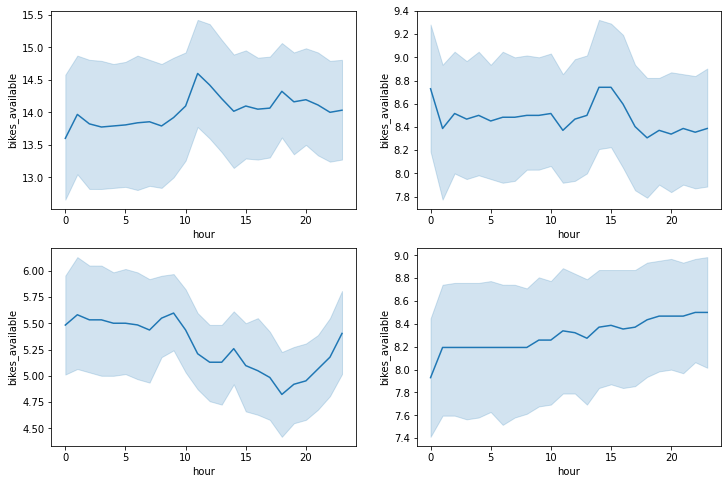

In [5]:
#bikes_availableの変動を可視化する
plt.figure(figsize=(12,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plot_df = status_df[(status_df["weekday"]=="土曜日")&(status_df["station_id"]==i)]
    sns.lineplot(x ='hour', y ='bikes_available',data = plot_df)

In [6]:
#これから細かい前処理をするためにmain_dfを作成
main_df = status_df[["date","month", "hour","station_id","bikes_available","weekday","predict"]]
# main_df = pd.merge(status_df, station_df[['city', 'station_id']], on='station_id')
main_df.head()

,date,month,hour,station_id,bikes_available,weekday,predict
0,2013-09-01,9,0,0,11.0,日曜日,0
1,2013-09-01,9,1,0,11.0,日曜日,0
2,2013-09-01,9,2,0,11.0,日曜日,0
3,2013-09-01,9,3,0,11.0,日曜日,0
4,2013-09-01,9,4,0,11.0,日曜日,0


In [7]:
# hourをカテゴリ変数化するために、後々並べ替えように使うhour列を複製
hour_cat = pd.DataFrame(main_df['hour'].copy())
# hour_cat.columns = ['hour_cat']

hour_cat = hour_cat.rename({'hour' : 'hour_cat'}, axis=1)
hour_cat.head()

,hour_cat
0,0
1,1
2,2
3,3
4,4


In [8]:
hour_cat.astype({'hour_cat' : 'str'})
main_df = pd.concat([main_df, hour_cat['hour_cat']], axis=1)

In [9]:
#カテゴリ変数をダミー変数化
main_df = pd.get_dummies(main_df, columns=['month', 'weekday', 'hour_cat'])
print(main_df.columns)
print(main_df.shape)

Index(['date', 'hour', 'station_id', 'bikes_available', 'predict', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekday_土曜日',
       'weekday_日曜日', 'weekday_月曜日', 'weekday_木曜日', 'weekday_水曜日',
       'weekday_火曜日', 'weekday_金曜日', 'hour_cat_0', 'hour_cat_1', 'hour_cat_2',
       'hour_cat_3', 'hour_cat_4', 'hour_cat_5', 'hour_cat_6', 'hour_cat_7',
       'hour_cat_8', 'hour_cat_9', 'hour_cat_10', 'hour_cat_11', 'hour_cat_12',
       'hour_cat_13', 'hour_cat_14', 'hour_cat_15', 'hour_cat_16',
       'hour_cat_17', 'hour_cat_18', 'hour_cat_19', 'hour_cat_20',
       'hour_cat_21', 'hour_cat_22', 'hour_cat_23'],
      dtype='object')
(1226400, 48)


In [10]:
# 新たな特徴量として、holidayを追加
import holidays

us_holidays = holidays.UnitedStates()
main_df['holiday'] = 0

for i in range(len(main_df)):
    if us_holidays.get(main_df['date'][i]):
        main_df['holiday'][i] = 1

In [11]:
main_df['holiday'].value_counts()

0    1191120
1      35280
Name: holiday, dtype: int64

In [12]:
#学習用のデータフレームを作成
train_dataset_df = main_df[main_df["date"]<"2014-09-01"]
#評価用のデータフレームを作成(使用するモデルの関係上、前日のデータが必要なため2014-08-31から取得)
evaluation_dataset_df = main_df[main_df["date"]>="2014-08-31"]

In [13]:
#学習用データの欠損値を確認
print(train_dataset_df.isnull().sum())

date                   0
hour                   0
station_id             0
bikes_available    21605
predict                0
month_1                0
month_2                0
month_3                0
month_4                0
month_5                0
month_6                0
month_7                0
month_8                0
month_9                0
month_10               0
month_11               0
month_12               0
weekday_土曜日            0
weekday_日曜日            0
weekday_月曜日            0
weekday_木曜日            0
weekday_水曜日            0
weekday_火曜日            0
weekday_金曜日            0
hour_cat_0             0
hour_cat_1             0
hour_cat_2             0
hour_cat_3             0
hour_cat_4             0
hour_cat_5             0
hour_cat_6             0
hour_cat_7             0
hour_cat_8             0
hour_cat_9             0
hour_cat_10            0
hour_cat_11            0
hour_cat_12            0
hour_cat_13            0
hour_cat_14            0
hour_cat_15            0


In [14]:
train_dataset_df[train_dataset_df["bikes_available"].isnull()].head()

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_15,hour_cat_16,hour_cat_17,hour_cat_18,hour_cat_19,hour_cat_20,hour_cat_21,hour_cat_22,hour_cat_23,holiday
420480,2013-09-01,0,24,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420481,2013-09-01,1,24,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420482,2013-09-01,2,24,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420483,2013-09-01,3,24,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420484,2013-09-01,4,24,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#各ステーション毎に、欠損値を後の値で埋める
train_dataset_df_new = pd.DataFrame()
for station_id in train_dataset_df["station_id"].unique().tolist():
    temp_df = train_dataset_df[train_dataset_df["station_id"]==station_id]
    temp_df = temp_df.fillna(method="bfill")
    train_dataset_df_new = pd.concat([train_dataset_df_new,temp_df])

print(train_dataset_df_new.isnull().sum())

date               0
hour               0
station_id         0
bikes_available    0
predict            0
month_1            0
month_2            0
month_3            0
month_4            0
month_5            0
month_6            0
month_7            0
month_8            0
month_9            0
month_10           0
month_11           0
month_12           0
weekday_土曜日        0
weekday_日曜日        0
weekday_月曜日        0
weekday_木曜日        0
weekday_水曜日        0
weekday_火曜日        0
weekday_金曜日        0
hour_cat_0         0
hour_cat_1         0
hour_cat_2         0
hour_cat_3         0
hour_cat_4         0
hour_cat_5         0
hour_cat_6         0
hour_cat_7         0
hour_cat_8         0
hour_cat_9         0
hour_cat_10        0
hour_cat_11        0
hour_cat_12        0
hour_cat_13        0
hour_cat_14        0
hour_cat_15        0
hour_cat_16        0
hour_cat_17        0
hour_cat_18        0
hour_cat_19        0
hour_cat_20        0
hour_cat_21        0
hour_cat_22        0
hour_cat_23  

In [16]:
temp_df#データセットを時系列に並び替える(後ほど説明)
train_df = train_dataset_df_new.sort_values(["date","hour","station_id"],ascending=True).reset_index(drop=True)
evaluation_dataset_df = evaluation_dataset_df.sort_values(["date","hour","station_id"],ascending=True).reset_index(drop=True)
#学習用データセット
train_df.head()

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_15,hour_cat_16,hour_cat_17,hour_cat_18,hour_cat_19,hour_cat_20,hour_cat_21,hour_cat_22,hour_cat_23,holiday
0,2013-09-01,0,0,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-09-01,0,1,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-09-01,0,2,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-09-01,0,3,9.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-09-01,0,4,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
train_df.tail()

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_15,hour_cat_16,hour_cat_17,hour_cat_18,hour_cat_19,hour_cat_20,hour_cat_21,hour_cat_22,hour_cat_23,holiday
613195,2014-08-31,23,65,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
613196,2014-08-31,23,66,9.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
613197,2014-08-31,23,67,7.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
613198,2014-08-31,23,68,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
613199,2014-08-31,23,69,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
#predictは特徴量として必要ないため、削除
train_df = train_df.drop(["predict", "date", "station_id", "hour"],axis=1)
train_df.head()

,bikes_available,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,hour_cat_15,hour_cat_16,hour_cat_17,hour_cat_18,hour_cat_19,hour_cat_20,hour_cat_21,hour_cat_22,hour_cat_23,holiday
0,11.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,8.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,5.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,9.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,8.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
train_df.tail()

,bikes_available,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,hour_cat_15,hour_cat_16,hour_cat_17,hour_cat_18,hour_cat_19,hour_cat_20,hour_cat_21,hour_cat_22,hour_cat_23,holiday
613195,10.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
613196,9.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
613197,7.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
613198,8.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
613199,10.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613200 entries, 0 to 613199
Data columns (total 45 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   bikes_available  613200 non-null  float64
 1   month_1          613200 non-null  uint8  
 2   month_2          613200 non-null  uint8  
 3   month_3          613200 non-null  uint8  
 4   month_4          613200 non-null  uint8  
 5   month_5          613200 non-null  uint8  
 6   month_6          613200 non-null  uint8  
 7   month_7          613200 non-null  uint8  
 8   month_8          613200 non-null  uint8  
 9   month_9          613200 non-null  uint8  
 10  month_10         613200 non-null  uint8  
 11  month_11         613200 non-null  uint8  
 12  month_12         613200 non-null  uint8  
 13  weekday_土曜日      613200 non-null  uint8  
 14  weekday_日曜日      613200 non-null  uint8  
 15  weekday_月曜日      613200 non-null  uint8  
 16  weekday_木曜日      613200 non-null  uint

In [21]:
# train_dfを、lstmと全結合用のdataframeに分割
train_lstm_df = train_df.loc[:,'bikes_available']
train_dense_df = train_df.drop('bikes_available', axis=1)

In [22]:
train_dense_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613200 entries, 0 to 613199
Data columns (total 44 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   month_1      613200 non-null  uint8
 1   month_2      613200 non-null  uint8
 2   month_3      613200 non-null  uint8
 3   month_4      613200 non-null  uint8
 4   month_5      613200 non-null  uint8
 5   month_6      613200 non-null  uint8
 6   month_7      613200 non-null  uint8
 7   month_8      613200 non-null  uint8
 8   month_9      613200 non-null  uint8
 9   month_10     613200 non-null  uint8
 10  month_11     613200 non-null  uint8
 11  month_12     613200 non-null  uint8
 12  weekday_土曜日  613200 non-null  uint8
 13  weekday_日曜日  613200 non-null  uint8
 14  weekday_月曜日  613200 non-null  uint8
 15  weekday_木曜日  613200 non-null  uint8
 16  weekday_水曜日  613200 non-null  uint8
 17  weekday_火曜日  613200 non-null  uint8
 18  weekday_金曜日  613200 non-null  uint8
 19  hour_cat_0   613200 non

In [24]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
train_lstm_df_scale = lstm_scaler.fit_transform(np.array(train_lstm_df).reshape(-1, 1))
train_dense_df_scale = lstm_scaler.fit_transform(train_dense_df)
bikes_available_scale = scaler_for_inverse.fit_transform(train_df[["bikes_available"]])
print(train_lstm_df_scale.shape)
print(train_dense_df_scale.shape)

(613200, 1)
(613200, 44)


In [25]:
#学習用のデータをモデルの学習用とモデルの精度の検証用に分割
#今回は、モデル用学習データ:精度用の検証データ = 8 : 2 に分割
length = len(train_lstm_df_scale)
train_size = int(length * 0.8)
test_size = length - train_size
train_lstm, test_lstm = train_lstm_df_scale[0:train_size,:], train_lstm_df_scale[train_size:length,:]
train_dense, test_dense = train_dense_df_scale[0:train_size,:], train_dense_df_scale[train_size:length,:]
print(train_lstm.shape)
print(test_lstm.shape)
print(train_dense.shape)
print(test_dense.shape)

(490560, 1)
(122640, 1)
(490560, 44)
(122640, 44)


In [26]:
# stationに関する前処理
station_df.head()

,station_id,lat,long,dock_count,city,installation_date
0,0,37.32973,-121.90178,27,city1,8/6/2013
1,1,37.33070,-121.88898,15,city1,8/5/2013
2,2,37.33399,-121.89490,11,city1,8/6/2013
3,3,37.33141,-121.89320,19,city1,8/5/2013
4,4,37.33672,-121.89407,15,city1,8/7/2013


In [ ]:
def create_lstm_dataset(dataset):
    dataX = []
    dataY = np.array([])
    #1680で1つのデータセットであるため、余りの分は使わない
    extra_num = len(dataset) % 70
    max_len = len(dataset)-extra_num
    for i in range(1680,max_len,70):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i-1680:i, j]
            xset.append(a)
        temp_array = np.array(dataset[i:i+70,0])
        dataY = np.concatenate([dataY,temp_array])
        dataX.append(xset)
    dataY = dataY.reshape(-1,70)
    return np.array(dataX), dataY  

In [97]:
def create_dense_dataset(dataset):
    data = []
    #1680で1つのデータセットであるため、余りの分は使わない
    extra_num = len(dataset) % 70
    max_len = len(dataset)-extra_num
    for i in range(max_len):
        if i % 70 == 0:
            data.append(dataset[i])
            
    return data 

In [140]:
trainX_lstm, trainY_lstm = create_lstm_dataset(train_lstm)
testX_lstm, testY_lstm = create_lstm_dataset(test_lstm)
# trainX_dense, trainY_dense = create_dataset(train_dense)
# testX_dense, testY_dense = create_dataset(test_dense)

#LSTMのモデルに入力用にデータの形を整形
trainX_lstm = np.reshape(trainX_lstm, (trainX_lstm.shape[0], trainX_lstm.shape[1], trainX_lstm.shape[2]))
testX_lstm = np.reshape(testX_lstm, (testX_lstm.shape[0], testX_lstm.shape[1], testX_lstm.shape[2]))
#入力データと正解データの形を確認
print(trainX_lstm.shape)
print(trainY_lstm.shape)

(6984, 1, 1680)
(6984, 70)


In [229]:
print(testX_lstm[0].shape)
print(testY_lstm.shape)

(1, 1680)
(1728, 70)


In [142]:
trainX_dense = np.array(create_dense_dataset(train_dense)[0:6984])
testX_dense = np.array(create_dense_dataset(test_dense)[0:1728])

In [269]:
type(trainX_dense)

numpy.ndarray

In [147]:
early_stopping =  EarlyStopping(monitor='loss', min_delta=0.0, patience=2,)

input_lstm = Input(shape=(trainX_lstm.shape[1],1680))
input_dense = Input(shape=(44))

date = Dense(units=44)(input_dense)
date = Dense(units=44)(date)

bike = LSTM(50, input_shape=(trainX_lstm.shape[1],1680))(input_lstm)
bike = Dense(30, activation='relu')(bike)

ccat = concatenate([date, bike])
end_dense = Dense(units=30, activation='relu')(ccat)
end_dense = Dense(70)(end_dense)

model = Model([input_lstm, input_dense], end_dense)

model.compile(loss='mean_squared_error', optimizer='adam')

In [148]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 44)]         0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 1, 1680)]    0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 44)           1980        input_16[0][0]                   
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 50)           346200      input_15[0][0]                   
____________________________________________________________________________________________

In [149]:
hist = model.fit([trainX_lstm, trainX_dense], trainY_lstm, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
6984/6984 - 11s - loss: 0.0126
Epoch 2/20
6984/6984 - 9s - loss: 0.0107
Epoch 3/20
6984/6984 - 9s - loss: 0.0103
Epoch 4/20
6984/6984 - 10s - loss: 0.0100
Epoch 5/20
6984/6984 - 9s - loss: 0.0098
Epoch 6/20
6984/6984 - 9s - loss: 0.0097
Epoch 7/20
6984/6984 - 9s - loss: 0.0096
Epoch 8/20
6984/6984 - 10s - loss: 0.0095
Epoch 9/20
6984/6984 - 9s - loss: 0.0095
Epoch 10/20
6984/6984 - 9s - loss: 0.0094
Epoch 11/20
6984/6984 - 9s - loss: 0.0093
Epoch 12/20
6984/6984 - 9s - loss: 0.0093
Epoch 13/20
6984/6984 - 10s - loss: 0.0093
Epoch 14/20
6984/6984 - 11s - loss: 0.0092
Epoch 15/20
6984/6984 - 10s - loss: 0.0092
Epoch 16/20
6984/6984 - 10s - loss: 0.0091
Epoch 17/20
6984/6984 - 9s - loss: 0.0090
Epoch 18/20
6984/6984 - 9s - loss: 0.0090
Epoch 19/20
6984/6984 - 9s - loss: 0.0090
Epoch 20/20
6984/6984 - 10s - loss: 0.0089


In [153]:
#学習済みモデルで予測
train_predict = model.predict([trainX_lstm, trainX_dense])
test_predict = model.predict([testX_lstm, testX_dense])

#スケールをもとに戻す
train_predict = scaler_for_inverse.inverse_transform(train_predict)
trainY_lstm = scaler_for_inverse.inverse_transform(trainY_lstm)
test_predict = scaler_for_inverse.inverse_transform(test_predict)
testY_lstm = scaler_for_inverse.inverse_transform(testY_lstm)

#各ステーションのスコアの平均値を算出
train_score_list = []
test_score_list = []
for i in range(70):
    trainscore = math.sqrt(mean_squared_error(trainY_lstm[:,i], train_predict[:,i]))
    train_score_list.append(trainscore)
    testscore = math.sqrt(mean_squared_error(testY_lstm[:,i], test_predict[:,i]))
    test_score_list.append(testscore)
    
print("trainのRMSE平均 : ",mean(train_score_list))
print("testのRMSE平均 : ",mean(test_score_list))

trainのRMSE平均 :  2.405044704449049
testのRMSE平均 :  3.16615520648035


In [154]:
#予測日とその前日を含むデータフレームを作成すると前日の日付データを返す関数
def make_sameday_thedaybefore_dataset(dataset,prediction_date):
    #前日の日付をtimedeltaで取得
    before_date = prediction_date - timedelta(days=1)
    prediction_date = str(prediction_date).split(" ")[0]
    before_date = str(before_date).split(" ")[0]
    #予測日とその前日を含むものだけを抽出
    temp_dataset = dataset[dataset["date"].isin([before_date,prediction_date])]
        
    return before_date,temp_dataset


#評価用のデータセットを作成する関数
def make_evaluation_dataset(dataset):
    output_df = pd.DataFrame()
    prediction_date_list = dataset[dataset["predict"]==1]["date"].tolist()
    for date in sorted(list(set(prediction_date_list))):
        before_date,temp_dataset = make_sameday_thedaybefore_dataset(dataset,date)
        #前日のbikes_availableに欠損値が含まれるかどうかの判定
        if temp_dataset[temp_dataset["date"]==before_date]["bikes_available"][1:].isnull().any(): 
            #各ステーションで予測日の０時で前日の1時以降のデータを置換
            #予測日のbikes_availableの置換は、後ほど別途処理するので今回は無視
            temp_dataset = temp_dataset.sort_values(["station_id","date","hour"]).fillna(method="bfill")
            temp_dataset = temp_dataset.sort_values(["date","hour","station_id"],ascending=True)
            #予測には、前日の1時からのデータしか使用しないので、0時のデータは除く
            output_df = pd.concat([output_df,temp_dataset.iloc[70:,:]])
        else: #欠損値なし　→ そのまま前日分のデータを利用
            output_df = pd.concat([output_df,temp_dataset.iloc[70:,:]])
        
    return output_df

In [181]:
evaluation_df = make_evaluation_dataset(evaluation_dataset_df)
evaluation_df.shape
#evaluation_df.tail()

(394800, 49)

In [184]:
df = make_sameday_thedaybefore_dataset(evaluation_df,evaluation_df[evaluation_df["predict"]==1]["date"].tolist()[0])

In [188]:
df

('2014-08-31',
            date  hour  station_id  bikes_available  predict  month_1  month_2  \
 70   2014-08-31     1           0             11.0        0        0        0   
 71   2014-08-31     1           1              9.0        0        0        0   
 72   2014-08-31     1           2              4.0        0        0        0   
 73   2014-08-31     1           3              8.0        0        0        0   
 74   2014-08-31     1           4              7.0        0        0        0   
 ...         ...   ...         ...              ...      ...      ...      ...   
 3355 2014-09-01    23          65              NaN        1        0        0   
 3356 2014-09-01    23          66              NaN        1        0        0   
 3357 2014-09-01    23          67              NaN        1        0        0   
 3358 2014-09-01    23          68              NaN        1        0        0   
 3359 2014-09-01    23          69              NaN        1        0        0   
 

In [336]:
#LSTMの出力結果でデータを補完しながら、提出用データフレームを作成する関数
def predict_eva_dataset(eva_dataset):
    submission_df = pd.DataFrame()
    #予測したbikes_availableを元のスケールに戻すための変数
    scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
    scale_y = scaler_for_inverse.fit_transform(eva_dataset[["bikes_available"]])
    prediction_date_list = eva_dataset[eva_dataset["predict"]==1]["date"].tolist()
    for date in sorted(list(set(prediction_date_list))):
        before_date, temp_eva_dataset = make_sameday_thedaybefore_dataset(eva_dataset,date)
        for i in range(0,1610,70):
            #モデルに入れるためのデータセット(1680×columns)
            temp_eva_dataset_train = temp_eva_dataset.iloc[i:1680+i,:]
            #predictは特徴量に使わないため、ここで削除
            temp_eva_dataset_train = temp_eva_dataset_train.drop("predict",axis=1)
            #データを標準化する
            temp_eva_dataset_scale = scaler.fit_transform(temp_eva_dataset_train.iloc[:,3:])
            
            #モデルに入力する形にデータを整形
            train_lstm = []
            xset = []
            for j in range(temp_eva_dataset_scale.shape[0]):
                a = temp_eva_dataset_scale[j, 0]
                xset.append(a)
            train_lstm.append(xset)
            train_lstm = np.array(train_lstm)
            train_lstm = np.reshape(train_lstm, (-1, 1, 1680))
            train_dense = temp_eva_dataset_scale[0,1:]
            train_dense = train_dense.reshape(1, 44)
            #学習済みlstmモデルで予測
            predict_scale = model.predict([train_lstm, train_dense])
            predict = scaler_for_inverse.inverse_transform(predict_scale)

            #次に使うbikes_availableに出力結果を補完
            temp_eva_dataset.iloc[1680+i:1750+i,3] = predict[0]

        submission_df= pd.concat([submission_df,temp_eva_dataset.iloc[1610:,:]])
        
    return submission_df

In [337]:
evaluation_df

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_15,hour_cat_16,hour_cat_17,hour_cat_18,hour_cat_19,hour_cat_20,hour_cat_21,hour_cat_22,hour_cat_23,holiday
70,2014-08-31,1,0,11.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,2014-08-31,1,1,9.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72,2014-08-31,1,2,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
73,2014-08-31,1,3,8.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,2014-08-31,1,4,7.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611515,2015-08-29,23,65,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
611516,2015-08-29,23,66,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
611517,2015-08-29,23,67,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
611518,2015-08-29,23,68,NaN,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


<AxesSubplot:xlabel='date', ylabel='bikes_available'>

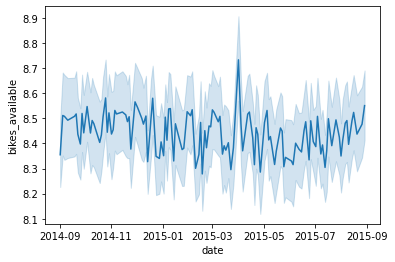

In [338]:
#予測した結果を時系列で可視化して確認
submission_df = predict_eva_dataset(evaluation_df)
sns.lineplot(x ='date', y ='bikes_available',data = submission_df)

In [339]:
submission_df[submission_df['predict']==1]

,date,hour,station_id,bikes_available,predict,month_1,month_2,month_3,month_4,month_5,...,hour_cat_15,hour_cat_16,hour_cat_17,hour_cat_18,hour_cat_19,hour_cat_20,hour_cat_21,hour_cat_22,hour_cat_23,holiday
1750,2014-09-01,1,0,13.029260,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1751,2014-09-01,1,1,7.990339,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1752,2014-09-01,1,2,5.603941,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1753,2014-09-01,1,3,10.235883,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1754,2014-09-01,1,4,7.471755,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611515,2015-08-29,23,65,17.981089,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
611516,2015-08-29,23,66,5.354755,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
611517,2015-08-29,23,67,4.348828,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
611518,2015-08-29,23,68,3.921427,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [340]:
lstm_submit_df = submission_df[submission_df["predict"]==1].sort_values(["station_id","date"])[["bikes_available"]]
lstm_submit_df["bikes_available"] = lstm_submit_df["bikes_available"].map(lambda x:0 if x < 0 else x)
lstm_submit_df.index = status_df[status_df["predict"]==1].index
lstm_submit_df.to_csv("lstm_submission.csv",header=None)#.head()

In [341]:
lstm_submit_df

,bikes_available
8761,13.029260
8762,13.284913
8763,13.107384
8764,13.140245
8765,12.946590
...,...
1226347,0.273513
1226348,0.118866
1226349,0.171938
1226350,0.450078


In [ ]:
lstm_submit_df.to_csv("/content/drive/MyDrive/studentcup_2021_fall/submit_file/lstm_submission.csv",header=None)#.head()